In [ ]:
!pip install scipy==1.1.0 #for imresize error
!pip install medpy

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 71kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753444 sha256=a794e1fd88c37b7b39b4d476efe2eca51a4dfe1054a1ccde702a570f0d7d25df
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf

In [ ]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import BatchNormalization,Convolution2D, Input, UpSampling2D, Activation, merge, MaxPooling2D, Deconvolution2D, Reshape, Permute
from keras.optimizers import SGD, Adam
from scipy.misc import imresize, imsave, imread
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from medpy.metric import dc, precision, recall
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


Using TensorFlow backend.


In [ ]:
#!pip install tensorflow

In [ ]:
#!pip install keras

In [ ]:
'''Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
Modified by He Xie 08/2016
For image segmentation problem data augmentation.
Transform train img data and mask img data simultaneously and in the same fashion.
Omit flow from directory function.
'''

import re
from scipy import linalg
import scipy.ndimage as ndi
# from six.moves import range
import os
import threading
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter


def random_channel_shift(x, intensity, channel_index=0):
    x = np.rollaxis(x, channel_index, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x, transform_matrix, channel_index=0, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, dim_ordering='default', scale=True):
    from PIL import Image
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering == 'th':
        x = x.transpose(1, 2, 0)
    if scale:
        x += max(-np.min(x), 0)
        x /= np.max(x)
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return Image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return Image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise Exception('Unsupported channel number: ', x.shape[2])


def img_to_array(img, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering not in ['th', 'tf']:
        raise Exception('Unknown dim_ordering: ', dim_ordering)
    # image has dim_ordering (height, width, channel)
    x = np.asarray(img, dtype='float32')
    if len(x.shape) == 3:
        if dim_ordering == 'th':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if dim_ordering == 'th':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise Exception('Unsupported image shape: ', x.shape)
    return x


class ImageDataGenerator(object):
    '''Generate minibatches with
    real-time data augmentation.
    Assume X is train img, Y is train label (same size as X with only 0 and 255 for values)
    # Arguments
        featurewise_center: set input mean to 0 over the dataset. Only to X
        samplewise_center: set each sample mean to 0. Only to X
        featurewise_std_normalization: divide inputs by std of the dataset. Only to X
        samplewise_std_normalization: divide each input by its std. Only to X
        zca_whitening: apply ZCA whitening. Only to X
        rotation_range: degrees (0 to 180). To X and Y
        width_shift_range: fraction of total width. To X and Y
        height_shift_range: fraction of total height. To X and Y
        shear_range: shear intensity (shear angle in radians). To X and Y
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range. To X and Y
        channel_shift_range: shift range for each channels. Only to X
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'. For Y, always fill with constant 0
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally. To X and Y
        vertical_flip: whether to randomly flip images vertically. To X and Y
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided (before applying
            any other transformation). Only to X
        dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension
            (the depth) is at index 1, in 'tf' mode it is at index 3.
            It defaults to the `image_dim_ordering` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "th".
    '''
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 
                 dim_ordering='default'):
        
        if dim_ordering == 'default':
            dim_ordering = K.common.image_dim_ordering()
        self.__dict__.update(locals())
        self.mean = None
        self.std = None
        self.principal_components = None
        self.rescale = rescale

        if dim_ordering not in {'tf', 'th'}:
            raise Exception('dim_ordering should be "tf" (channel after row and '
                            'column) or "th" (channel before row and column). '
                            'Received arg: ', dim_ordering)
        self.dim_ordering = dim_ordering
        if dim_ordering == 'th':
            self.channel_index = 1
            self.row_index = 2
            self.col_index = 3
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise Exception('zoom_range should be a float or '
                            'a tuple or list of two floats. '
                            'Received arg: ', zoom_range)

    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)

    def standardize(self, x):
        # Only applied to X
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)

        if self.featurewise_center:
            x -= self.mean
        if self.featurewise_std_normalization:
            x /= (self.std + 1e-7)

        if self.zca_whitening:
            flatx = np.reshape(x, (x.size))
            whitex = np.dot(flatx, self.principal_components)
            x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))

        return x

    def random_transform(self, x, y):
        # Need to modify to transform both X and Y ---- to do
        # x is a single image, so it doesn't have image number at index 0
        img_row_index = self.row_index - 1
        img_col_index = self.col_index - 1
        img_channel_index = self.channel_index - 1

        # use composition of homographies to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_index]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_index]
        else:
            ty = 0

        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])

        transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)

        h, w = x.shape[img_row_index], x.shape[img_col_index]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        # For y, mask data, fill mode constant, cval = 0
        y = apply_transform(y, transform_matrix, img_channel_index,
                            fill_mode="constant", cval=0)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x, self.channel_shift_range, img_channel_index)

        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_index)
                y = flip_axis(y, img_col_index)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_index)
                y = flip_axis(y, img_row_index)

        # TODO:
        # channel-wise normalization
        # barrel/fisheye
        return x, y

    def fit(self, X,
            augment=False,
            rounds=1,
            seed=None):
        '''Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            X: Numpy array, the data to fit on.
            augment: whether to fit on randomly augmented samples
            rounds: if `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Only applied to X
        '''
        X = np.copy(X)
        if augment:
            aX = np.zeros(tuple([rounds * X.shape[0]] + list(X.shape)[1:]))
            for r in range(rounds):
                for i in range(X.shape[0]):
                    aX[i + r * X.shape[0]] = self.random_transform(X[i])
            X = aX

        if self.featurewise_center:
            self.mean = np.mean(X, axis=0)
            X -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(X, axis=0)
            X /= (self.std + 1e-7)

        if self.zca_whitening:
            flatX = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            sigma = np.dot(flatX.T, flatX) / flatX.shape[1]
            U, S, V = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(U, np.diag(1. / np.sqrt(S + 10e-7))), U.T)


class Iterator(object):

    def __init__(self, N, batch_size, shuffle, seed):
        self.N = N
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(N, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):
        # ensure self.batch_index is 0
        self.reset()
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    if seed is not None:
                        np.random.seed(seed + self.total_batches_seen)
                    index_array = np.random.permutation(N)

            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        # ?
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):

    def __init__(self, X, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dim_ordering='default',
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if len(X) != len(y):
            raise Exception('X (images tensor) and y (labels) '
                            'should have the same length. '
                            'Found: X.shape = %s, y.shape = %s' % (np.asarray(X).shape, np.asarray(y).shape))
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.X = X
        self.y = y
        self.image_data_generator = image_data_generator
        self.dim_ordering = dim_ordering
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(X.shape[0], batch_size, shuffle, seed)

    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        batch_y = np.zeros(tuple([current_batch_size] + list(self.y.shape)[1:]))
        for i, j in enumerate(index_array):
            x = self.X[j]
            label = self.y[j]
            x, label = self.image_data_generator.random_transform(x.astype('float32'), label.astype("float32"))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = label
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                mask = array_to_img(batch_y[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}_mask.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                mask.save(os.path.join(self.save_to_dir, fname))
        return batch_x, batch_y




In [ ]:
def dice_coef(y_true, y_pred):
    
    #y_pred = K.round(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def create_model(learn = 3e-4):
    inputs = Input((256, 512,1))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',init='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same',init='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same',init='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    input6 = UpSampling2D(size=(2, 2))(conv5)
    input6 = Convolution2D(128,2,2,border_mode='same')(input6)
    
    up6 =  keras.layers.concatenate([input6, conv4])
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same',init='he_normal')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Convolution2D(128, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    input7 = UpSampling2D(size=(2, 2))(conv6)
    input7 = Convolution2D(64,2,2,border_mode='same')(input7)
  
    up7 = keras.layers.concatenate([input7, conv3])
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='he_normal')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    input8 = UpSampling2D(size=(2, 2))(conv7)
    input8 = Convolution2D(32,2,2,border_mode='same')(input8)
  
    up8 = keras.layers.concatenate([input8, conv2])
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='he_normal')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    input9 = UpSampling2D(size=(2, 2))(conv8)
    input9 = Convolution2D(16,2,2,border_mode='same')(input9)
    
    up9 = keras.layers.concatenate([input9, conv1])
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',init='he_normal')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',init='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Convolution2D(1, 1, 1,border_mode='same')(conv9)

    conv11 = Activation('sigmoid')(conv10)

    model = Model(input=inputs, output=conv11)

    model.compile(optimizer=Adam(lr=learn), loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])

    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
train_X = np.load('unet/optima data/train_cutimages_conall.npy')
train_y = np.load('unet/optima data/train_cutground.npy')

print(train_y.shape)
#print np.unique(train_y)

(1676, 256, 512)


In [ ]:
train_X = np.reshape(train_X, (-1,256,512,1))
train_y = np.reshape(train_y*1, (-1,256,512,1))

train_X = train_X.astype('float32')
train_y = train_y.astype('float32')

print(train_X.shape)
print(train_y.shape)


(1676, 256, 512, 1)
(1676, 256, 512, 1)


In [ ]:
print(np.max(train_X))

255.0


In [ ]:

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, fill_mode='constant', dim_ordering=K.common.image_dim_ordering())

datagen.fit(train_X)

In [ ]:
mean = np.mean(train_X)
std = np.std(train_X)
print (mean, std)

67.86644 56.091488


In [ ]:
import keras

In [ ]:
#K.clear_session()
model = create_model()
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
  # This is added back by InteractiveS

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 512, 16) 2320        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
bestdc = 0

In [ ]:
test1_X = np.load('unet/optima data/test1_cutimages_conall.npy')
test1_y1 = np.load('unet/optima data/test1_cutgrader1.npy')
test1_y2 = np.load('unet/optima data/test1_cutgrader2.npy')
test1_y3 = np.load('unet/optima data/test1_cutgrader3.npy')

print (test1_y1.shape)
print (np.max(test1_X))

(620, 256, 512)
255


In [ ]:
test1_X = np.reshape(test1_X, (-1,256,512,1))
test1_y1 = np.reshape(test1_y1*1, (-1,256,512,1))
test1_y2 = np.reshape(test1_y2*1, (-1,256,512,1))
test1_y3 = np.reshape(test1_y3*1, (-1,256,512,1))

test1_X = test1_X.astype('float32')
test1_y1 = test1_y1.astype('float32')
test1_y2 = test1_y2.astype('float32')
test1_y3 = test1_y3.astype('float32')

print (test1_X.shape)
print (test1_y1.shape)
print (test1_y2.shape)
print (test1_y3.shape)

(620, 256, 512, 1)
(620, 256, 512, 1)
(620, 256, 512, 1)
(620, 256, 512, 1)


In [ ]:
mean = np.mean(train_X)
std = np.std(train_X)
print (mean, std)


67.86644 56.091488


In [ ]:
res1 = test1_X - mean
res1 = res1 / std
print (res1.shape)

(620, 256, 512, 1)


In [ ]:
print (np.max(res1))

3.3362203


In [ ]:
#Validation Data Creation

val_x = []
val_gt = []
val_x.append(test1_X[0:128])
val_gt.append(test1_y3[0:128])

val_x.append(test1_X[128:256])
val_gt.append(test1_y3[128:256])

val_x.append(test1_X[256:261])
val_gt.append(test1_y3[256:261])

val_x.append(test1_X[261:266])
val_gt.append(test1_y3[261:266])

val_x.append(test1_X[266:315])
val_gt.append(test1_y3[266:315])

val_x.append(test1_X[315:364])
val_gt.append(test1_y3[315:364])

val_x.append(test1_X[364:492])
val_gt.append(test1_y3[364:492])

val_x.append(test1_X[492:620])
val_gt.append(test1_y3[492:620])

val_x = np.array(val_x)
val_gt = np.array(val_gt)



val_x = val_x - mean
val_x = val_x / std

print (val_x.shape)
print (val_gt.shape)

(8,)
(8,)


In [ ]:
print (np.max(val_x[0]))

3.3362203


In [ ]:
model_checkpoint = ModelCheckpoint('unet_trial', monitor='val_loss', save_best_only=True)

In [ ]:
epochs = 50
for i in range(epochs):
    print(i)
    history= model.fit_generator(datagen.flow(train_X, train_y, batch_size=4), nb_epoch=1, samples_per_epoch=len(train_X))                           
    total=0
    for j in range(8):
        val_pred = model.predict(val_x[j], batch_size=4)
        val_result = np.zeros(val_pred.shape)
        #print test1_result.shape
        val_result[val_pred>0.5] = 1
        dice = dc(val_result,val_gt[j])
        print("Volume "+str(j)+": "+str(dice))
        total += dice
    mean = total/8.0
    print ("Average dc: "+str(mean))
    if mean > bestdc:
        model.save_weights('best2_new7.h5')
        bestdc = mean
        #test1results(model)
        #test2results(model)
    print ("Best dc: "+str(bestdc))
    print ("")

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., steps_per_epoch=419, epochs=1)`
  after removing the cwd from sys.path.


Epoch 1/1
419/419 [==============================] - 163s 390ms/step - loss: 0.5171 - dice_coef: 0.0423 - accuracy: 0.8969
Volume 0: 0.0
Volume 1: 0.25415404972136696
Volume 2: 0.4370079687989022
Volume 3: 0.41160782010815045
Volume 4: 0.2891782874265299
Volume 5: 0.017308918648082355
Volume 6: 0.28426676255666716
Volume 7: 0.5773763547033389
Average dc: 0.2838625202453797
Best dc: 0.2838625202453797

1
Epoch 1/1
419/419 [==============================] - 151s 361ms/step - loss: 0.2232 - dice_coef: 0.0747 - accuracy: 0.9856
Volume 0: 0.0
Volume 1: 0.5295097572584484
Volume 2: 0.5859000357867112
Volume 3: 0.6971365322140126
Volume 4: 0.47843934477501077
Volume 5: 0.108680635505411
Volume 6: 0.3956729812656425
Volume 7: 0.6510061634158834
Average dc: 0.43079318127763994
Best dc: 0.43079318127763994

2
Epoch 1/1
419/419 [==============================] - 151s 361ms/step - loss: 0.1008 - dice_coef: 0.1383 - accuracy: 0.9887
Volume 0: 0.0
Volume 1: 0.24982435739031422
Volume 2: 0.6084057170

In [ ]:
#model.load_weights('unet_best2')

In [ ]:
model.save('unet_bestreena')

In [ ]:
test1_pred = model.predict(res1, batch_size=4)
test1_result = np.zeros(test1_pred.shape)
print(test1_result.shape)
test1_result[test1_pred>0.5] = 1

(620, 256, 512, 1)


In [ ]:
from medpy.metric.binary import hd
#from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [ ]:
x,y = 492,620
a = test1_result[x:y]
b = test1_y1[x:y]
c = test1_y2[x:y]
d = test1_y3[x:y]


TP1 = np.sum(np.logical_and(a == 1, b == 1))
TP2 = np.sum(np.logical_and(a == 1, c == 1))
TP3 = np.sum(np.logical_and(a == 1, d == 1))

 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN1 = np.sum(np.logical_and(a == 0, b == 0))
TN2 = np.sum(np.logical_and(a == 0, c == 0))
TN3 = np.sum(np.logical_and(a == 0, d == 0))

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP1 = np.sum(np.logical_and(a == 1, b == 0))
FP2 = np.sum(np.logical_and(a == 1, c == 0))
FP3 = np.sum(np.logical_and(a == 1, d == 0))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN1 = np.sum(np.logical_and(a == 0, b == 1))
FN2 = np.sum(np.logical_and(a == 0, c == 1))
FN3 = np.sum(np.logical_and(a == 0, d == 1))




In [ ]:
def test1results(model):
    
    frames = [(0,128),(128,256),(256,261),(261,266),(266,315),(315,364),(364,492),(492,620)]
    test1resarray = []
    
    print ("\nTEST 1 RESULTS: ")
    for item in frames:
        x = item[0]
        y = item[1]
        
        test1_pred = model.predict(res1[x:y], batch_size=4)
        test1_result = np.zeros(test1_pred.shape)
        #print test1_result.shape
        test1_result[test1_pred>0.5] = 1
        test1resarray.append(test1_result)
        
        a = test1_result
        b = test1_y1[x:y]
        c = test1_y2[x:y]
        d = test1_y3[x:y]
        
        print ("")
        print (dc(a, b))
        print (dc(a, c))
        print (dc(a, d))

        print (recall(a, b))
        print (recall(a, c))
        print (recall(a, d))

        print (precision(a, b))
        print (precision(a, c))
        print (precision(a, d))
        
        """
        for i in range(test1_pred.shape[0]):
            imsave('test1_results/'+str(i+x)+'.jpg',test1_X[i+x,:,:,0])
            imsave('test1_results/'+str(i+x)+'g.jpg',test1_y3[i+x,:,:,0])
            imsave('test1_results/'+str(i+x)+'p.jpg',test1_result[i,:,:,0]*255)
        
    test1resarray = np.array(test1resarray)
    np.save('test1results')
    """

In [ ]:
test1results(model)
#test1results(0:128)
#test1results(128:256)


TEST 1 RESULTS: 

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.3801103302350185
0.36793136107861163
0.42429167581814187
0.23755549258524605
0.22897163858262257
0.2763978710009729
0.9504913076341648
0.9359410430839002
0.9126039304610734

0.6145511874412988
0.6414105000983156
0.6119951040391677
0.8721793773207654
0.8733601070950469
0.915467533137346
0.47441607540525144
0.5068102957170232
0.4596302242477601

0.7432090885882052
0.7358881476076305
0.6838413309330188
0.9357000514271021
0.956684510096219
0.9811380504700643
0.6164034047598882
0.5978974337257559
0.5248157872448548

0.7446481452178041
0.7543950014556693
0.7652251085366146
0.7127155498820831
0.7159465261099658
0.7757191139640626
0.7795763814933144
0.7972074310732458
0.7550112412732221

0.12280822388778107
0.11973484325369424
0.1172592748439582
0.5395770392749245
0.5439146800501882
0.6097738876732313
0.06928926132836748
0.06727188081936686
0.0648665425201738

0.40304629209777815
0.43490444689452407
0.47956724185154753
0.266714858561335

TypeError: ignored

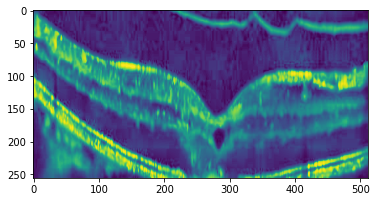

In [ ]:
from skimage import data, exposure, img_as_float
from pylab import *
for i in range(5):
    cimg = exposure.equalize_adapthist(test1_X[340,:,:,0].astype(np.uint8), kernel_size = (32,64))
    imshow(cimg)
    #imshow(test1_X[i,:,:,0])
    #imshow(test1_y3[340,:,:,0])
    #imshow(test1_result[340,:,:,0]*255)

    #imsave('test1_batch/'+str(i)+'c.jpg',cimg)
    #imsave('test1_results/'+str(i)+'.jpg',test1_X[i,:,:,0])
    #imsave('test1_results/'+str(i)+'g.jpg',test1_y3[i,:,:,0])
    #imsave('test1_results/'+str(i)+'p.jpg',test1_result[i,:,:,0]*255)

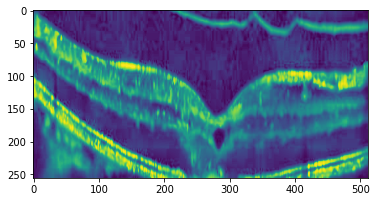

In [ ]:
cimg = exposure.equalize_adapthist(test1_X[340,:,:,0].astype(np.uint8), kernel_size = (32,64))
imshow(cimg)

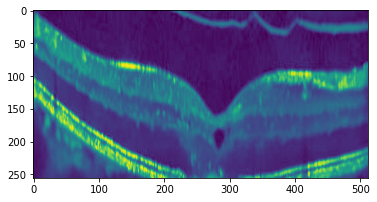

In [ ]:
imshow(test1_X[340,:,:,0])
    

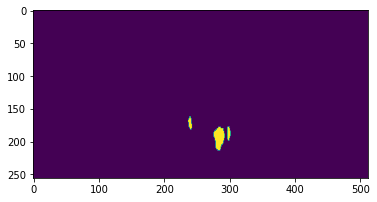

In [ ]:
imshow(test1_y3[340,:,:,0])    

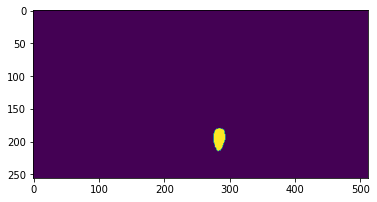

In [ ]:
imshow(test1_result[340,:,:,0]*255)

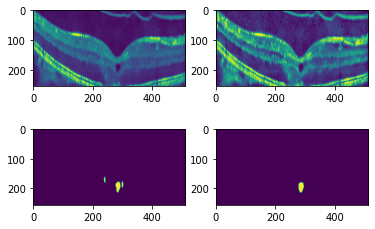

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,1].imshow(exposure.equalize_adapthist(test1_X[340,:,:,0].astype(np.uint8), kernel_size = (32,64)))
axarr[1,1].imshow(test1_result[340,:,:,0]*255)
axarr[1,0].imshow(test1_y3[340,:,:,0])
axarr[0,0].imshow(test1_X[340,:,:,0])

In [ ]:
test2_X = np.load('unet/optima data/test2_cutimages_conall.npy')
test2_y1 = np.load('unet/optima data/test2_cutgrader1.npy')
test2_y2 = np.load('unet/optima data/test2_cutgrader2.npy')
test2_y3 = np.load('unet/optima data/test2_cutgrader3.npy')

print (test2_y1.shape)
print (np.max(test2_X))

(289, 256, 512)
255


In [ ]:
test2_X = np.reshape(test2_X, (-1,256,512,1))
test2_y1 = np.reshape(test2_y1*1, (-1,256,512,1))
test2_y2 = np.reshape(test2_y2*1, (-1,256,512,1))
test2_y3 = np.reshape(test2_y3*1, (-1,256,512,1))

test2_X = test2_X.astype('float32')
test2_y1 = test2_y1.astype('float32')
test2_y2 = test2_y2.astype('float32')
test2_y3 = test2_y3.astype('float32')


print (test2_X.shape)
print (test2_y1.shape)
print (test2_y2.shape)
print (test2_y3.shape)

(289, 256, 512, 1)
(289, 256, 512, 1)
(289, 256, 512, 1)
(289, 256, 512, 1)


In [ ]:
mean = np.mean(train_X)
std = np.std(train_X)
print (mean, std)

67.86644 56.091488


In [ ]:
res2 = test2_X - mean
res2 = res2 / std
print (res2.shape)

(289, 256, 512, 1)


In [ ]:
test2_pred = model.predict(res2, batch_size=4)
test2_result = np.zeros(test2_pred.shape)
#print test2_result.shape
test2_result[test2_pred>0.5] = 1

In [ ]:
x,y = 282,289
a = test2_result[x:y]
b = test2_y1[x:y]
c = test2_y2[x:y]
d = test2_y3[x:y]

print (dc(a, b))
print (dc(a, c))
print (dc(a, d))

print (recall(a, b))
print (recall(a, c))
print (recall(a, d))

print (precision(a, b))
print (precision(a, c))
print (precision(a, d))

0.361394814770049
0.3612670384701558
0.34155043987370876
0.9783071033602723
0.9866375603625058
0.9875212705615428
0.22163416279362821
0.2211152868272217
0.20648298457455877


In [ ]:
def test2results(model):
    
    frames = [(0,128),(128,256),(256,261),(261,268),(268,275),(275,282),(282,289)]
    test2resarray = []
    
    print ("\nTEST 2 RESULTS: ")
    for item in frames:
        x = item[0]
        y = item[1]
        
        test2_pred = model.predict(res2[x:y], batch_size=4)
        test2_result = np.zeros(test2_pred.shape)
        #print test1_result.shape
        test2_result[test2_pred>0.5] = 1
        test2resarray.append(test2_result)
        
        a = test2_result
        b = test2_y1[x:y]
        c = test2_y2[x:y]
        d = test2_y3[x:y]
        
        print ("")
        print (dc(a, b))
        print (dc(a, c))
        print (dc(a, d))

        print (recall(a, b))
        print (recall(a, c))
        print (recall(a, d))

        print (precision(a, b))
        print (precision(a, c))
        print (precision(a, d))
        
        for i in xrange(test2_pred.shape[0]):
            imsave('test2_results/'+str(i+x)+'.jpg',test2_X[i+x,:,:,0])
            imsave('test2_results/'+str(i+x)+'g.jpg',test2_y3[i+x,:,:,0])
            imsave('test2_results/'+str(i+x)+'p.jpg',test2_result[i,:,:,0]*255)
    
    test2resarray = np.array(test2resarray)
    np.save('test2results')

In [ ]:
"""for i in range(289):
    imsave('test2_results/'+str(i)+'.jpg',test2_X[i,:,:,0])
    imsave('test2_results/'+str(i)+'g.jpg',test2_y3[i,:,:,0])
    imsave('test2_results/'+str(i)+'p.jpg',test2_result[i,:,:,0]*255)"""

In [ ]:
"""i = 288
val_img.append(test2_X[i,:,:,0])
val_gt.append(test2_y3[i,:,:,0])
print (len(val_img))"""

In [ ]:
"""val_img = np.array(val_img)
val_gt = np.array(val_gt)
print val_img.shape
print val_gt.shape"""

In [ ]:
"""np.save('val_imgs',val_img)
np.save('val_gt',val_gt)"""

In [ ]:
test3_X = np.load('duke_cutimg.npy')
test3_y1 = np.load('duke_cutg1.npy')
test3_y2 = np.load('duke_cutg2.npy')
test3_y3 = np.load('duke_cutg3.npy')

print test3_y1.shape
print np.max(test3_X)

In [ ]:
test3_X = np.reshape(test3_X, (-1,256,512,1))
test3_y1 = np.reshape(test3_y1*1, (-1,256,512,1))
test3_y2 = np.reshape(test3_y2*1, (-1,256,512,1))
test3_y3 = np.reshape(test3_y3*1, (-1,256,512,1))

test3_X = test3_X.astype('float32')
test3_y1 = test3_y1.astype('float32')
test3_y2 = test3_y2.astype('float32')
test3_y3 = test3_y3.astype('float32')


print test3_X.shape
print test3_y1.shape
print test3_y2.shape
print test3_y3.shape

In [ ]:
print mean, std

In [ ]:
res3 = test3_X - mean
res3 = res3 / std
print res3.shape

In [ ]:
test3_pred = model.predict(res3, batch_size=4)

In [ ]:
test3_result = np.zeros(test3_pred.shape)
print test3_result.shape

In [ ]:
test3_result[test3_pred>0.5] = 1

In [ ]:
x,y = 128,256
a = test3_result[x:y]
b = test3_y1[x:y]
c = test3_y2[x:y]
d = test3_y3[x:y]

In [ ]:
print (dc(a, b))
print (dc(a, c))
print (dc(a, d))

print (recall(a, b))
print (recall(a, c))
print (recall(a, d))

print (precision(a, b))
print (precision(a, c))
print (precision(a, d))

In [ ]:
for i in xrange(73):
    imsave('duke_results/'+str(i)+'.jpg',test3_X[i,:,:,0])
    imsave('duke_results/'+str(i)+'g.jpg',test3_y3[i,:,:,0])
    imsave('duke_results/'+str(i)+'p.jpg',test3_result[i,:,:,0]*255)